# TITLEE

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import copy
from IPython.display import Image
from qutip import *
import time
import json

In [2]:
dim = 2      # number of levels for each qubit
GHz = 1e8    #1e9 (0.1GHz)
ns = 1e-9
b = destroy(dim)                     # sigma minus operator

s0m = tensor(b, qeye(dim))           # sigma minus on 0
s0p = tensor(b.dag(), qeye(dim))     # sigma plus on 0
s1m = tensor(qeye(dim), b)           # sigma minus on 1
s1p = tensor(qeye(dim), b.dag())     # sigma plus on 1

omega = [2*np.pi*5.0*GHz, 2*np.pi*5.2*GHz]            # qubit transition frequencies [rad/s]
Delta = [2*np.pi*0*GHz,2*np.pi*0*GHz] #[-.33, -.33]   # anharmonicities [rad/s]
Omega = [2*np.pi*1*GHz, 2*np.pi*1.1*GHz]              # control-qubit drive strength [rad/s]
# J = 2*np.pi*0.3*GHz                                     # passive interaction [rad/s]

c_max = 10  # upper bound for control amplitudes
c_min = -10   # lower bound for control amplitudes
T = 10*ns   # target time
L = 10     # number of piecewise constants (at most 20)

# H0 = ( omega[0]*s0p*s0m + omega[1]*s1p*s1m ) + \
#      (1/2)*( Delta[0]*s0p*s0p*s0m*s0m + Delta[1]*s1p*s1p*s1m*s1m ) + \
#      J*(s0p*s1m+s0m*s1p)

Hc0m = Omega[0]*(s0m)
Hc1m = Omega[1]*(s1m)
Hc0p = Omega[0]*(s0p)
Hc1p = Omega[1]*(s1p)

# Piecewise Constant Control on qubit 0
def C0(t, args):
    c = args['c']     # list of control parameters [c11,...,c1L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[0][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[0][L-1]*float(t==t_inv[L])  )

def C1(t, args):
    c = args['c']     # list of control parameters [c21,...,c2L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[1][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[1][L-1]*float(t==t_inv[L])  )

# Piecewise Constant Control on qubit 1
def C2(t, args):
    c = args['c']     # list of control parameters [c31,...,c3L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[2][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[2][L-1]*float(t==t_inv[L])  )

def C3(t, args):
    c = args['c']     # list of control parameters [c41,...,c4L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[3][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[3][L-1]*float(t==t_inv[L])  )

# Marker
def ep0(t, args):
    omega = args['omega']
    return np.exp(1j *omega[0]*t)

def em0(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[0]*t)

def ep1(t, args):
    omega = args['omega']
    return np.exp(1j *omega[1]*t)

def em1(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[1]*t)

# Control Functions C_i_j_k: i=0,1; j=m,p related to sm/sp; k=m,p related to (sm-sp) or (sm+sp)
def C0mm(t, args):
    return 1j*C0(t, args)*ep0(t, args)
def C0pm(t, args):
    return -1j*C0(t, args)*em0(t, args)

def C0mp(t, args):
    return C1(t, args)*ep0(t, args)
def C0pp(t, args):
    return C1(t, args)*em0(t, args)

def C1mm(t, args):
    return 1j*C2(t, args)*ep1(t, args)
def C1pm(t, args):
    return -1j*C2(t, args)*em1(t, args)

def C1mp(t, args):
    return C3(t, args)*ep1(t, args)
def C1pp(t, args):
    return C3(t, args)*em1(t, args)

# # Total Hamiltonain
# H = [H0, [Hc0m,C0mm], [Hc0p,C0pm], [Hc0m,C0mp], [Hc0p,C0pp], [Hc1m,C1mm], [Hc1p,C1pm], [Hc1m,C1mp], [Hc1p,C1pp]]   

In [3]:
GA = sigmax() # Target Unitary on qubit 0
GB = sigmax() # Target Unitary on qubit 1

In [4]:
def OBJ(c,T,L,omega,H,GA,GB):
    
    args = {
        'c': c,
        'T': T,
        'L': L,
        'omega': omega
    }
    
    U = propagator(H, T, args=args,options=Options(nsteps=2000))
    
    # SVD for partial traces
    sigma = np.sqrt((((tensor(GA,qeye(dim)).dag()*U).ptrace(1))*((tensor(GA,qeye(dim)).dag()*U).ptrace(1)).dag()).eigenstates()[0])
    lambd = np.sqrt((((tensor(qeye(dim),GB).dag()*U).ptrace(0))*((tensor(qeye(dim),GB).dag()*U).ptrace(0)).dag()).eigenstates()[0])
    
    # sum of fidelity
    return sum(sigma)/(2*dim**2)+sum(lambd)/(2*dim**2)

In [5]:
# GRadient Ascent Pulse Engineering (GRAPE)

def GRAPE(T,L,omega,H,GA,GB):
    eps = 0.01  # ascending rate
    threshold = 0.00001  # if cost changes less than threshold, then halt
    itera_max = 1000     # max iteration number
    count = 0           # counting iterations
    diff_cost = np.inf  # initial cost difference
    d = T/L             # time interval length
    record_cost = []

    # Step1-1, Guess initial
    c = [[float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C1
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C2
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C3
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)]]    # for C4

    # Step1-2, Compute initial cost
    cost = OBJ(c,T,L,omega,H,GA,GB)
    record_cost.append(cost)


    # Start while loop
    while (count<=itera_max) and (diff_cost>threshold):   
        count += 1
    
        # Step 2, compute derivative numerically by Df(x0) = (f(x0+dx)-f(x0)) / dx
        dx = 0.01
        D_J_c = [ [ 0 for l in range(L)] for m in range(4)]
        for m in range(4):
            for l in range(L):
                c_tmp = copy.deepcopy(c)
                c_tmp[m][l] += dx
                D_J_c[m][l] += (OBJ(c_tmp,T,L,omega,H,GA,GB) - OBJ(c,T,L,omega,H,GA,GB)) / dx
    
        # Step 3, normalization for gradient
        norm2_D = 0
        for m in range(4):
            for l in range(L):
                norm2_D += D_J_c[m][l]**2
            
        norm_D = np.sqrt(norm2_D)
    
        D_J_c = [[ eps*D_J_c[m][l]/norm_D for l in range(L)] for m in range(4)]
    
        # Step4, gradient ascend
        c = np.array(c) + np.array(D_J_c)    
     
    
        # Step5, Compute cost 
        new_cost = OBJ(c,T,L,omega,H,GA,GB)
        if new_cost > record_cost[-1]:
            record_cost.append(new_cost)
            diff_cost = record_cost[-1] - record_cost[-2]
            eps = min(eps+0.01,0.09)   # set upper bound for the learning rate
        else:
            eps = 0.01
            # Repeat Step 2, compute derivative numerically by Df(x0) = (f(x0+dx)-f(x0)) / dx
            dx = 0.01
            D_J_c = [ [ 0 for l in range(L)] for m in range(4)]
            for m in range(4):
                for l in range(L):
                    c_tmp = copy.deepcopy(c)
                    c_tmp[m][l] += dx
                    D_J_c[m][l] += (OBJ(c_tmp,T,L,omega,H,GA,GB) - OBJ(c,T,L,omega,H,GA,GB)) / dx
    
            # Repeat Step 3, normalization for gradient
            norm2_D = 0
            for m in range(4):
                for l in range(L):
                    norm2_D += D_J_c[m][l]**2
            
            norm_D = np.sqrt(norm2_D)
    
            D_J_c = [[ eps*D_J_c[m][l]/norm_D for l in range(L)] for m in range(4)]
    
            # Repeat Step4, gradient ascend
            c = np.array(c) + np.array(D_J_c)    
     
    
            # Repeat Step5, Compute cost 
            new_cost = OBJ(c,T,L,omega,H,GA,GB)
            record_cost.append(new_cost)
            diff_cost = record_cost[-1] - record_cost[-2]

    return record_cost, c
    

In [6]:
record_c = []
record_f = {} # array of dict
n_trails = 50

J = 2*np.pi*GHz                                     # passive interaction [rad/s]
H0 = ( omega[0]*s0p*s0m + omega[1]*s1p*s1m ) + \
    (1/2)*( Delta[0]*s0p*s0p*s0m*s0m + Delta[1]*s1p*s1p*s1m*s1m ) + \
    J*(s0p*s1m+s0m*s1p)
# Total Hamiltonain
H = [H0, [Hc0m,C0mm], [Hc0p,C0pm], [Hc0m,C0mp], [Hc0p,C0pp], [Hc1m,C1mm], [Hc1p,C1pm], [Hc1m,C1mp], [Hc1p,C1pp]]   
    
for i in range(n_trails): # apply GRAPE with random initial multiple times
    fidelity,c = GRAPE(T,L,omega,H,GA,GB)
    record_f.update({i: fidelity})
    record_c.append(c)
    print('i=',i) # check progress
    
with open("1crosstalk.json",'w') as outfile:
    json.dump(record_f, outfile)


i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49


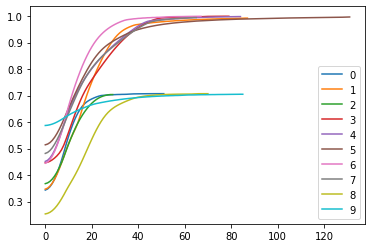

In [7]:
import matplotlib.patches as mpatches

handles = []
fig, ax = plt.subplots()

with open('1crosstalk.json') as json_file:
    data = json.load(json_file)
for i in range(10):
    plt.plot(data[str(i)])
    handles.append(i)
ax.legend(handles)
plt.show()

In [8]:
optima = [[] for trail in range(10)]

for trail in range(10):
    print('trail=',trail)
    c = record_c[trail]
    for j in range(11): # for each J
        J = 2*np.pi*j*GHz/10                                     # passive interaction [rad/s]
        H0 = ( omega[0]*s0p*s0m + omega[1]*s1p*s1m ) + \
             (1/2)*( Delta[0]*s0p*s0p*s0m*s0m + Delta[1]*s1p*s1p*s1m*s1m ) + \
             J*(s0p*s1m+s0m*s1p)
        # Total Hamiltonain
        H = [H0, [Hc0m,C0mm], [Hc0p,C0pm], [Hc0m,C0mp], [Hc0p,C0pp], [Hc1m,C1mm], [Hc1p,C1pm], [Hc1m,C1mp], [Hc1p,C1pp]]   
        print('j=',j) # check progress
    
        optima[trail].append(OBJ(c,T,L,omega,H,GA,GB))

trail= 0
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 1
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 2
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 3
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 4
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 5
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 6
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 7
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 8
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
trail= 9
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10


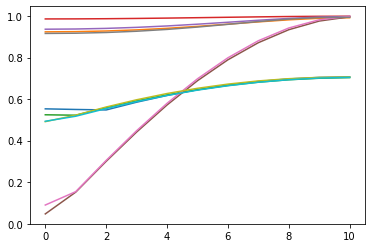

In [9]:
for trail in range(10):
    plt.plot(optima[trail])
plt.show()